In [1]:
import glob
import os

import pandas as pd
from cision import (add_hash, append_filename, clean_up, convert_numbers,
                    drop_empty_headlines, guess_date, guess_encoding,
                    normalise_column_names, patch_column_names, save_csv,
                    logger)

The media files are downloaded to `working/manual/media` with a `dvc` url import. The files are uploaded to files.open-innovations.org by AMA, who are LEEDS 2023's media partner.

In [2]:
WORKING_DIR = '../../../working/manual/media/'

Get the list of input files and work out which is the latest date in the column

In [3]:
files=glob.glob('*.csv', root_dir=WORKING_DIR)
input_files = pd.Series(
    files, index=files, name='latest_input_date'
).str.lower().str.replace(
    r'(leeds 2023.*?media coverage( w\.e\.*)*\s*([\d\.]*-){0,1}|.csv$)', '', regex=True
).str.strip().pipe(pd.to_datetime, format='%d.%m.%y', errors='coerce').sort_values()

List files with invalid dates

In [4]:
input_files.loc[input_files.isna()].to_frame()

,latest_input_date


Load the cision date into a long 

In [5]:
required_columns = set([
    'news_date', 'news_headline', 'outlet_name', 'audience_reach', 'uv'
])


def load_cision_file(filename):
    source_file = os.path.basename(filename)
    print(source_file)
    latest_date = input_files.loc[source_file]
    logger.info('Loading %s', source_file)
    logger.info('Latest date %s', str(latest_date))

    try:
        data = pd.read_csv(
            filename,
            encoding=guess_encoding(filename),
            thousands=',',
            skipinitialspace=True
        )
    except Exception as e:
        logger.warning('Cannot process %s', filename)
        logger.info(e)
        return

    # print(data.pipe(normalise_column_names).pipe(patch_column_names)['uv'].fillna(0).astype('Int64'))
    data = (
        data
        .pipe(add_hash)
        .pipe(append_filename, source_file)
        .pipe(normalise_column_names)
        .pipe(patch_column_names)
        .pipe(drop_empty_headlines)
        .pipe(guess_date, latest_date=latest_date)
        .pipe(convert_numbers)
    )

    data['latest_date'] = latest_date

    # Check for expected columns
    try:
        assert required_columns.issubset(data.columns)
    except:
        missing = required_columns.difference(data.columns)
        logger.warning("Missing columns %s in %s", missing, filename)
        logger.info("Got columns %r", data.columns)
        return

    return data

In [6]:
cision_data = pd.concat([
    load_cision_file(os.path.join(WORKING_DIR, f))
    for f in
    input_files.loc[input_files.notna()].index.to_list()
])

Leeds 2023 media coverage 23.09.22-17.10.22.csv
Leeds 2023 weekly media coverage 24.11.22.csv
Leeds 2023 weekly media coverage 02.12.22.csv
Leeds 2023 weekly media coverage 09.12.22.csv
Leeds 2023 weekly media coverage 16.12.22.csv
Leeds 2023 weekly media coverage 23.12.22.csv
Leeds 2023 weekly media coverage 1-6.01.23.csv
LEEDS 2023 The Awakening media coverage 7-9.01.23.csv
Leeds 2023 weekly media coverage w.e. 13.01.23.csv
Leeds 2023 weekly media coverage 13-20.01.23.csv
Leeds 2023 weekly media coverage 21-27.01.23.csv
Leeds 2023 weekly media coverage w.e 03.02.23.csv
LEEDS 2023 weekly media coverage W.e 10.02.23.csv
LEEDS 2023 Weekly Media Coverage w.e. 17.02.23.csv
LEEDS 2023 weekly media coverage w.e. 24.02.23.csv
LEEDS 2023 weekly media coverage w.e. 03.03.23.csv
Leeds 2023 weekly media coverage w.e. 10.03.23.csv
Leeds 2023 weekly media coverage w.e. 17.03.23.csv
Leeds 2023 weekly media coverage 24.03.23.csv
leeds 2023 weekly media coverage w.e. 31.03.23.csv
Leeds 2023 weekly me

LEEDS 2023 Weekly media coverage w.e. 02.06.23.csv
LEEDS 2023 Weekly media coverage w.e. 09.06.23.csv
LEEDS 2023 Weekly media coverage w.e. 16.06.23.csv
LEEDS 2023 Weekly media coverage w.e. 23.06.23.csv
LEEDS 2023 Weekly media coverage 30.06.23.csv
LEEDS 2023 Weekly media coverage w.e 07.07.23 .csv
LEEDS 2023 Weekly media coverage w.e 14.07.23.csv
LEEDS 2023 Weekly media coverage w.e. 21.07.23.csv
LEEDS 2023 weekly media coverage w.e 28.07.23.csv
Leeds 2023 weekly media coverage 29.07-18.08.23.csv
LEEDS 2023 Weekly media coverage w.e 08.09.23.csv
LEEDS 2023 Weekly media coverage 09.09.23-03.11.23.csv


Print missing dates

In [7]:
cision_data[cision_data.news_date.isna()].loc[:, ['news_date', 'input_date', 'source_file']]

,news_date,input_date,source_file
0,NaT,1/1/2023,Leeds 2023 weekly media coverage 23.12.22.csv
1,NaT,1/1/2023,Leeds 2023 weekly media coverage 23.12.22.csv
23,NaT,01.08.23,LEEDS 2023 Weekly media coverage w.e. 21.07.23...


In [8]:
CISION_FILE = '../../../data/metrics/media_coverage/combined_cision.csv'
os.makedirs(os.path.dirname(CISION_FILE), exist_ok=True)

cision_data.loc[cision_data.news_date.notna()].pipe(clean_up).pipe(save_csv, output_file=CISION_FILE)

,news_date,news_headline,outlet_name,audience_reach,uv,tone,medium,outlet_type,custom_tags,news_company_mentions,hash,source_file,latest_date,input_date
236,2022-09-17,Four West Leeds sites earmarked for local auth...,West Leeds Dispatch,0,3141.0,POS,Online,"Online, consumer",Local,Leeds 2023,13479499968123036765,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,17/09/2022
237,2022-09-17,Inspirational Bramley Baths hailed a 'beacon f...,West Leeds Dispatch,0,3141.0,NEU,Online,"Online, consumer",Local,Leeds 2023,453098313913252842,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,17/09/2022
235,2022-09-17,Support Leeds 2023 city of culture by voluntee...,West Leeds Dispatch,0,3141.0,NEU,Online,"Online, consumer",Local,Leeds 2023,10670817045611648545,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,17/09/2022
234,2022-09-17,Youths shift 34 tonnes as new Bramley eco peac...,West Leeds Dispatch,0,3141.0,NEU,Online,"Online, consumer",Local,Leeds 2023,13785126224380383013,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,17/09/2022
233,2022-09-20,Inspirational Bramley Baths hailed a 'beacon f...,West Leeds Dispatch,0,3141.0,NEU,Online,"Online, consumer",Local,Leeds 2023,12296830178779861036,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,20/09/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,2023-11-02,Radio clip from BBC Leeds at 2023-11-02 09:47:...,BBC Radio Leeds,78000,0.0,NEU,Broadcast,NaN,NaN,NaN,1023971215112660833,LEEDS 2023 Weekly media coverage 09.09.23-03.1...,2023-11-03,02/11/2023
236,2023-11-03,LIFF 2023 Programme Preview,"Gryphon - www.thegryphon.co.uk, The",0,1638.0,POS,Online,NaN,NaN,NaN,5382099588182015276,LEEDS 2023 Weekly media coverage 09.09.23-03.1...,2023-11-03,03/11/2023
239,2023-11-03,Leeds Architecture Awards honour innovations i...,Bradford Zone,0,0.0,POS,Online,NaN,NaN,NaN,8389772923225667567,LEEDS 2023 Weekly media coverage 09.09.23-03.1...,2023-11-03,03/11/2023
237,2023-11-03,New multi-media exhibition 'This is a FOREST' ...,Yorkshire Bylines,0,8326.0,NEU,Online,NaN,NaN,NaN,9558766405138936321,LEEDS 2023 Weekly media coverage 09.09.23-03.1...,2023-11-03,03/11/2023


Plot the number of days in a week where data is available. This shows potential gaps in the data.

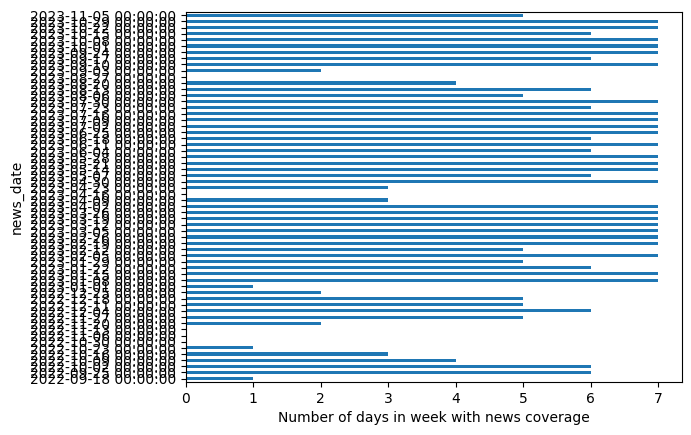

In [9]:
ax = cision_data.groupby('news_date').news_headline.count().resample('W').count().plot.barh(
  xlabel='Number of days in week with news coverage'
)